In [5]:
import numpy as np
import flexcode
from flexcode.regression_models import XGBoost
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from flexcode.loss_functions import cde_loss
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

train = np.load('trainz_train.npz', allow_pickle=True)
test = np.load('trainz_test.npz', allow_pickle=True)

In [58]:
# Part 1: Preparing the Data
train_data = pd.DataFrame(train['train_cat'])
test_data = pd.DataFrame(test['test_cat'])

In [50]:
df_train = train_data.assign(
    ug = train_data.U - train_data.G,
    gr = train_data.G - train_data.R,
    ri = train_data.R - train_data.I,
    iz = train_data.I - train_data.Z,
    zy = train_data.Z - train_data.Y,
    ug_err = np.sqrt(train_data['UERR'] ** 2 + train_data['GERR'] ** 2),
    gr_err = np.sqrt(train_data['GERR'] ** 2 + train_data['RERR'] ** 2),
    ri_err = np.sqrt(train_data['RERR'] ** 2 + train_data['IERR'] ** 2),
    iz_err = np.sqrt(train_data['IERR'] ** 2 + train_data['ZERR'] ** 2),
    zy_err = np.sqrt(train_data['ZERR'] ** 2 + train_data['YERR'] ** 2)
)

df_test = test_data.assign(
    ug = test_data.U - test_data.G,
    gr = test_data.G - test_data.R,
    ri = test_data.R - test_data.I,
    iz = test_data.I - test_data.Z,
    zy = test_data.Z - test_data.Y,
    ug_err = np.sqrt(test_data['UERR'] ** 2 + test_data['GERR'] ** 2),
    gr_err = np.sqrt(test_data['GERR'] ** 2 + test_data['RERR'] ** 2),
    ri_err = np.sqrt(test_data['RERR'] ** 2 + test_data['IERR'] ** 2),
    iz_err = np.sqrt(test_data['IERR'] ** 2 + test_data['ZERR'] ** 2),
    zy_err = np.sqrt(test_data['ZERR'] ** 2 + test_data['YERR'] ** 2)
)

In [52]:
train_features = df_train[ ['ug', 'gr','ri','iz', 'zy', 'ug_err', 'gr_err', 'ri_err', 'iz_err', 'zy_err', 'I'] ] #training features (mag ratios and errors, and I)
test_features = df_test[ ['ug', 'gr','ri','iz', 'zy', 'ug_err', 'gr_err', 'ri_err', 'iz_err', 'zy_err', 'I'] ] #training features (mag ratios and errors, and I)


train_label = df_train['SPECZ'].to_numpy()
test_label = df_test['SPECZ'].to_numpy()

In [15]:
train_features.head()

,ug,gr,ri,iz,zy,ug_err,gr_err,ri_err,iz_err,zy_err,I
0,0.923601,0.464600,0.233200,0.148600,0.188100,0.007071,0.007071,0.007071,0.007071,0.007071,16.209900
1,1.328299,0.765900,0.450102,0.273699,0.302000,0.007142,0.007071,0.007071,0.007071,0.007071,16.528799
2,0.627401,0.181999,0.200300,-0.026899,0.127199,0.008500,0.007142,0.007142,0.007284,0.008246,20.628300
3,0.993200,0.315498,0.181900,-0.031898,0.102200,0.007433,0.007071,0.007071,0.007071,0.007142,19.056801
4,0.550201,0.121500,0.129000,-0.042801,0.029600,0.007951,0.007142,0.007142,0.007284,0.008169,20.437099


In [60]:
# Part 2: Generating PDFs

# Standardize inputs
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_features_scaled, train_label, train_size=0.8, random_state=1)

In [1]:
# DONT RUN CELL, results are saved in the next cell
from itertools import product
from sklearn.metrics import mean_squared_error
import time

param_grid = {
    "n_estimators": [100, 500, 1000],
    "max_depth": [5, 7],
    "min_child_weight": [1, 2],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "gamma": [0, 0.3],
    "verbosity": [0],
    "objective": ['reg:squarederror']
}

# Create all combinations
param_names = list(param_grid.keys())
combinations = list(product(*param_grid.values()))

best_score = -1
best_params = None
best_basis = 'none'
best_max_basis = 0

for combo in combinations:
    for basis in ["cosine", "Fourier", "db4"]:
        for max_basis in [31, 41, 51]:
            params = dict(zip(param_names, combo))
        
            model = flexcode.FlexCodeModel(
                XGBoost,
                max_basis=max_basis,
                basis_system=basis,
                regression_params=params,
            )
        
            model.fit(X_train, y_train)
            model.tune(X_val, y_val)
            temp_cdes, temp_z_grid = model.predict(X_val, n_grid=200)
            score = -cde_loss(temp_cdes, temp_z_grid, y_val)
            
            print(f"Params: {params}, Score: {score}")
        
            if score > best_score:
                best_score = score
                best_params = params
                best_basis = basis
                best_max_basis = max_basis

print(f"\nBest score: {best_score}")
print(f"Best parameters: {best_params}")
print(best_basis)
print(best_max_basis)

NameError: name 'flexcode' is not defined

In [19]:
# Results from the gridsearch
best_max_basis = 51
best_basis = 'cosine'
best_params = {
        'n_estimators': 1000, 
        'max_depth': 7, 
        'min_child_weight': 2, 
        'learning_rate': 0.05, 
        'subsample': 0.8, 
        'colsample_bytree': 0.8, 
        'gamma': 0, 
        'verbosity': 0, 
        'objective': 'reg:squarederror', 
        'silent': 1
    }

model = flexcode.FlexCodeModel(
    XGBoost,
    max_basis=best_max_basis,
    basis_system=best_basis,
    regression_params=best_params
)

# Train the model
model.fit(X_train, y_train)
model.tune(X_val, y_val)

In [24]:
# On the LSST DC1 Data
cdes, z_grid = model.predict(test_features_scaled, n_grid=200)

In [32]:
# Test cde loss
from flexcode.loss_functions import cde_loss
print(f"The cde_loss is: {cde_loss(cdes, z_grid, test_label)}")

The cde_loss is: -8.926446735961022


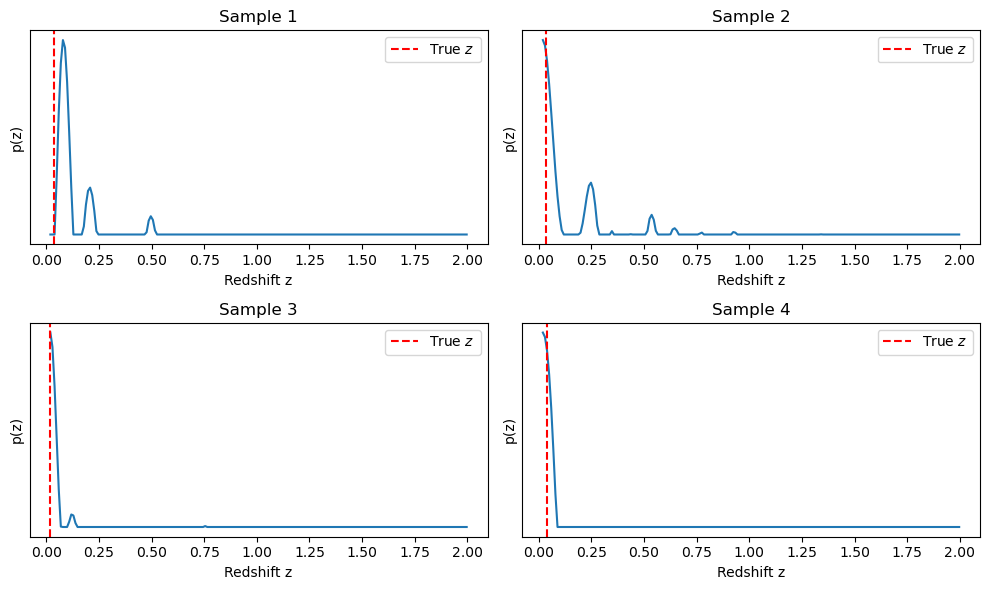

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2 rows, 2 columns

for ii in range(4):
    row, col = divmod(ii, 2)
    ax = axes[row, col]
    ax.plot(z_grid, cdes[ii, :])
    ax.axvline(x=test_label[ii], color="red", linestyle="--", label="True $z$")
    ax.set_title(f"Sample {ii + 1}")
    ax.set_xlabel("Redshift z")
    ax.set_ylabel("p(z)")
    ax.set_yticks([])
    ax.legend()

plt.tight_layout()
plt.savefig('photo_z_pdfs.pdf')
plt.show()

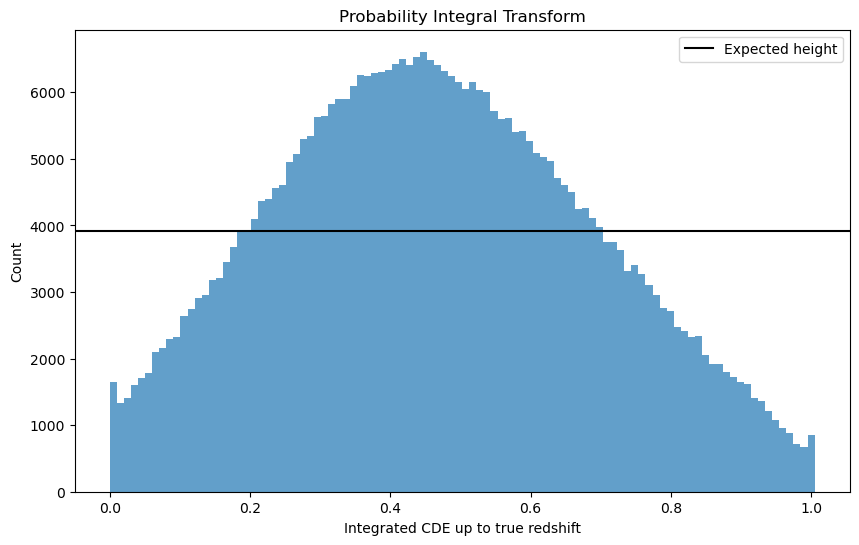

In [62]:
# Part 3: Evaluating the Model

# Making the PIT
pdf = cdes[0]
z = z_grid.flatten()

hist = []
n_samples = 390990
n_bins = 100

for i in range(n_samples):
    z_range = z[z <= test_label[i]]
    cde_range = cdes[i][:len(z_range)]
    hist.append(np.trapz(cde_range, z_range))

plt.figure(figsize=(10, 6))
plt.hist(hist, bins=n_bins, alpha=0.7)

# Add horizontal line at expected height assuming uniform distribution
plt.axhline(y=n_samples / n_bins, color='black', linestyle='-', label='Expected height')

plt.xlabel("Integrated CDE up to true redshift")
plt.ylabel("Count")
plt.title("Probability Integral Transform")
plt.legend()
plt.savefig('photo_z_pit.pdf')
plt.show()

    